In [ ]:
import pandas as pd

In [ ]:
train = pd.read_excel('/content/drive/MyDrive/FakeNewsData/fakeNewsData/Constraint_English_Train.xlsx')
val = pd.read_excel('/content/drive/MyDrive/FakeNewsData/fakeNewsData/Constraint_English_Val.xlsx')

In [ ]:
train.head(5)

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [ ]:
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
#Remove stop words
import nltk as nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
tweets = train['tweet'].values.tolist()

In [ ]:
tweets[0]

'The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.'

In [ ]:
def token_builder(sentences) :
   for sent in sentences:     
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  


In [ ]:
tweet_tokens = list(token_builder(tweets))

In [ ]:
tweet_tokens[0]

['the',
 'cdc',
 'currently',
 'reports',
 'deaths',
 'in',
 'general',
 'the',
 'discrepancies',
 'in',
 'death',
 'counts',
 'between',
 'different',
 'sources',
 'are',
 'small',
 'and',
 'explicable',
 'the',
 'death',
 'toll',
 'stands',
 'at',
 'roughly',
 'people',
 'today']

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tweet_tokens, min_count=3, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_tokens], threshold=50)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could','be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come','co','https'])

In [ ]:
def process_docs(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization   
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out] 
    return texts_out


In [ ]:
tweets_data = process_docs(tweet_tokens)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(tweets_data)

In [ ]:
print(id2word.token2id)

{'count': 0, 'currently': 1, 'death': 2, 'different': 3, 'discrepancy': 4, 'explicable': 5, 'general': 6, 'people': 7, 'report': 8, 'roughly': 9, 'small': 10, 'source': 11, 'stand': 12, 'today': 13, 'last': 14, 'rise': 15, 'state': 16, 'almost': 17, 'bag': 18, 'correct': 19, 'excuse': 20, 'pandemic': 21, 'plastic': 22, 'politically': 23, 'reuse': 24, 'woman': 25, 'icmrdelhi': 26, 'laboratory': 27, 'test': 28, 'testing': 29, 'case': 30, 'generate': 31, 'large': 32, 'look': 33, 'new': 34, 'populous': 35, 'show': 36, 'average': 37, 'datum': 38, 'decline': 39, 'factor': 40, 'fe': 41, 'find': 42, 'hhigdd': 43, 'infect': 44, 'order': 45, 'person': 46, 'place': 47, 'put': 48, 'rate': 49, 'restriction': 50, 'stay_home': 51, 'time': 52, 'away': 53, 'covid': 54, 'learn': 55, 'recommendation': 56, 'symptom': 57, 'call': 58, 'chaotic': 59, 'dedqzehasb': 60, 'disaster': 61, 'clearly': 62, 'game_plan': 63, 'kind': 64, 'leave': 65, 'analysis': 66, 'chloroquine': 67, 'lancet': 68, 'macrolide': 69, 'mu

In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tweets_data]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [ ]:
print(lda_model.print_topics())

[(0, '0.123*"number" + 0.119*"confirm" + 0.042*"week" + 0.027*"care" + 0.025*"tell" + 0.025*"late" + 0.020*"publish" + 0.017*"economy" + 0.017*"reach" + 0.015*"drtedro"'), (1, '0.356*"covid" + 0.050*"risk" + 0.035*"community" + 0.024*"give" + 0.022*"treatment" + 0.019*"full" + 0.017*"recommend" + 0.013*"explain" + 0.011*"false" + 0.010*"join"'), (2, '0.043*"update" + 0.036*"doctor" + 0.029*"world" + 0.024*"government" + 0.024*"follow" + 0.022*"share" + 0.016*"immunity" + 0.016*"video" + 0.015*"recent" + 0.015*"reduce"'), (3, '0.054*"yesterday" + 0.050*"remain" + 0.035*"record" + 0.031*"bring" + 0.026*"situation" + 0.025*"quarantine" + 0.024*"available" + 0.019*"information" + 0.018*"stay" + 0.018*"tests_completed"'), (4, '0.078*"virus" + 0.038*"low" + 0.030*"child" + 0.027*"support" + 0.025*"infection" + 0.024*"become" + 0.022*"create" + 0.021*"currently" + 0.018*"different" + 0.016*"fall"'), (5, '0.189*"people" + 0.058*"pandemic" + 0.028*"mask" + 0.026*"never" + 0.024*"learn" + 0.022*

In [ ]:
from wordcloud import WordCloud

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)





In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=tweets_data)

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.3644,"report, state, death, last, active, transmissi...","[currently, report, death, general, discrepanc..."
1,1,8.0,0.8963,"report, state, death, last, active, transmissi...","[state, report, death, small, rise, last, repo..."
2,2,5.0,0.6378,"people, pandemic, mask, never, learn, suggest,...","[politically, correct, woman, almost, pandemic..."
3,3,14.0,0.8133,"test, day, testing, set, visit, outbreak, long...","[testing, laboratory, test, icmrdelhi]"
4,4,7.0,0.5117,"case, new, today, recover, recovery, look, loc...","[populous, state, generate, large, case, count..."
5,5,6.0,0.7793,"show, datum, time, person, way, find, call, ma...","[find, average, person, infect, people, datum,..."
6,6,5.0,0.6329,"people, pandemic, mask, never, learn, suggest,...","[covid, symptom, stay_home, away, people, lear..."
7,7,6.0,0.4416,"show, datum, time, person, way, find, call, ma...","[call, chaotic, disaster, dedqzehasb]"
8,8,2.0,0.6110,"update, doctor, world, government, follow, sha...","[clearly, leave, kind, game_plan]"
9,9,1.0,0.7490,"covid, risk, community, give, treatment, full,...","[retraction, chloroquine, macrolide, treatment..."


In [ ]:
train.head(5)

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [ ]:
df_dominant_topic['label'] = train['label']

In [ ]:
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.3644,"report, state, death, last, active, transmissi...","[currently, report, death, general, discrepanc..."
1,1,8.0,0.8963,"report, state, death, last, active, transmissi...","[state, report, death, small, rise, last, repo..."
2,2,5.0,0.6378,"people, pandemic, mask, never, learn, suggest,...","[politically, correct, woman, almost, pandemic..."
3,3,14.0,0.8133,"test, day, testing, set, visit, outbreak, long...","[testing, laboratory, test, icmrdelhi]"
4,4,7.0,0.5117,"case, new, today, recover, recovery, look, loc...","[populous, state, generate, large, case, count..."


In [ ]:
#score 
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tweets_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4316100803500762


In [ ]:
df_dominant_topic['label'] = train['label']

In [ ]:
df_dominant_topic.groupby("Dominant_Topic").label.value_counts()

Dominant_Topic  label
0.0             real     222
                fake     211
1.0             real     159
                fake     155
2.0             fake     297
                real      87
3.0             real     195
                fake     144
4.0             fake     287
                real     173
5.0             real     216
                fake     199
6.0             fake     268
                real     155
7.0             real     617
                fake      89
8.0             real     352
                fake      50
9.0             fake     344
                real     100
10.0            fake     200
                real     192
11.0            fake     238
                real     206
12.0            fake     218
                real     172
13.0            fake     290
                real     144
14.0            real     370
                fake      70
Name: label, dtype: int64

In [ ]:
dfu = df_dominant_topic.groupby("Dominant_Topic").label.value_counts().unstack()

NameError: ignored

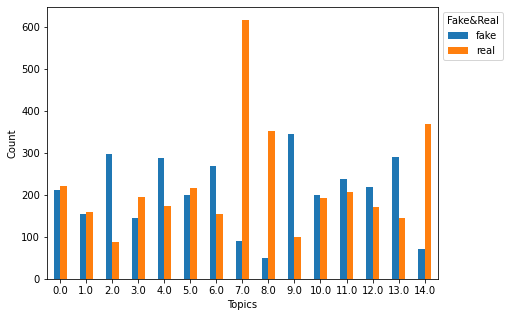

In [ ]:

# plot
ax = dfu.plot(kind='bar', figsize=(7, 5), xlabel='Topics', ylabel='Count', rot=0)
ax.legend(title='Fake&Real', bbox_to_anchor=(1, 1), loc='upper left')
plt.title("Topic wise fake and real tweets comparison")

In [ ]:
#Building model with 2 topics
# Build LDA model
# lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=2, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=10,
#                                            passes=10,
#                                            alpha='symmetric',
#                                            iterations=100,
#                                            per_word_topics=True)

lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta = 0.61,
                                           iterations=100,
                                           per_word_topics=True)

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model2, texts=tweets_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.48728301630792586


In [ ]:
print(lda_model2.print_topics())

[(0, '0.070*"case" + 0.029*"report" + 0.029*"test" + 0.026*"covid" + 0.026*"state" + 0.026*"new" + 0.023*"death" + 0.018*"number" + 0.017*"confirm" + 0.015*"today"'), (1, '0.038*"people" + 0.029*"covid" + 0.012*"spread" + 0.011*"country" + 0.010*"risk" + 0.008*"amp" + 0.007*"work" + 0.006*"mask" + 0.006*"visit" + 0.005*"child"'), (2, '0.021*"claim" + 0.020*"vaccine" + 0.019*"virus" + 0.019*"covid" + 0.017*"pandemic" + 0.014*"die" + 0.014*"patient" + 0.010*"doctor" + 0.010*"hospital" + 0.008*"cure"'), (3, '0.011*"news" + 0.011*"government" + 0.010*"lockdown" + 0.010*"measure" + 0.009*"man" + 0.009*"police" + 0.009*"restriction" + 0.008*"announce" + 0.007*"add" + 0.006*"explain"')]


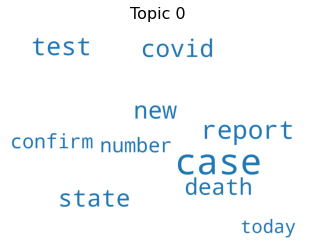

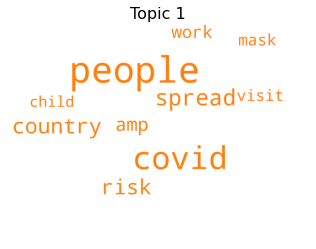

In [ ]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model2.show_topics(formatted=False)
for i in range(0,2):
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    plt.show()


In [ ]:

topics = lda_model2.show_topics(formatted=False)

In [ ]:

topics

[(0,
  [('case', 0.0701615),
   ('report', 0.029498627),
   ('test', 0.028517896),
   ('covid', 0.026413726),
   ('state', 0.026191244),
   ('new', 0.02602658),
   ('death', 0.023362173),
   ('number', 0.017988263),
   ('confirm', 0.017316636),
   ('today', 0.014943904)]),
 (1,
  [('people', 0.0384777),
   ('covid', 0.028734127),
   ('spread', 0.011964982),
   ('country', 0.010663466),
   ('risk', 0.010270071),
   ('amp', 0.008006418),
   ('work', 0.0066663423),
   ('mask', 0.0057424745),
   ('visit', 0.0056848205),
   ('child', 0.0051519955)]),
 (2,
  [('claim', 0.020584354),
   ('vaccine', 0.020027911),
   ('virus', 0.019368129),
   ('covid', 0.019155689),
   ('pandemic', 0.01654614),
   ('die', 0.013844307),
   ('patient', 0.013613669),
   ('doctor', 0.010467149),
   ('hospital', 0.010410543),
   ('cure', 0.007769237)]),
 (3,
  [('news', 0.010862843),
   ('government', 0.010543032),
   ('lockdown', 0.009745963),
   ('measure', 0.009706587),
   ('man', 0.009291801),
   ('police', 0.0

In [ ]:
 dict(topics[0][1])

{'case': 0.0701615,
 'confirm': 0.017316636,
 'covid': 0.026413726,
 'death': 0.023362173,
 'new': 0.02602658,
 'number': 0.017988263,
 'report': 0.029498627,
 'state': 0.026191244,
 'test': 0.028517896,
 'today': 0.014943904}

In [ ]:
df_topic_keywords = format_topics_sentences(ldamodel=lda_model2, corpus=corpus, texts=tweets_data)


In [ ]:
# Format
df_dominant_topic2 = df_topic_keywords.reset_index()
df_dominant_topic2.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic2.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.8113,"case, report, test, covid, state, new, death, ...","[currently, report, death, general, discrepanc..."
1,1,0.0,0.9321,"case, report, test, covid, state, new, death, ...","[state, report, death, small, rise, last, repo..."
2,2,2.0,0.3073,"claim, vaccine, virus, covid, pandemic, die, p...","[politically, correct, woman, almost, pandemic..."
3,3,0.0,0.8778,"case, report, test, covid, state, new, death, ...","[testing, laboratory, test, icmrdelhi]"
4,4,0.0,0.9588,"case, report, test, covid, state, new, death, ...","[populous, state, generate, large, case, count..."
5,5,1.0,0.3695,"people, covid, spread, country, risk, amp, wor...","[find, average, person, infect, people, datum,..."
6,6,1.0,0.9042,"people, covid, spread, country, risk, amp, wor...","[covid, symptom, stay_home, away, people, lear..."
7,7,2.0,0.8300,"claim, vaccine, virus, covid, pandemic, die, p...","[call, chaotic, disaster, dedqzehasb]"
8,8,3.0,0.6120,"news, government, lockdown, measure, man, poli...","[clearly, leave, kind, game_plan]"
9,9,2.0,0.9029,"claim, vaccine, virus, covid, pandemic, die, p...","[retraction, chloroquine, macrolide, treatment..."


In [ ]:
df_dominant_topic2['label'] = train['label']

In [ ]:

df_dominant_topic2.groupby("Dominant_Topic").label.value_counts()

Dominant_Topic  label
0.0             real     1949
                fake      514
1.0             real     1031
                fake      755
2.0             fake     1230
                real      205
3.0             fake      561
                real      175
Name: label, dtype: int64

In [ ]:
dfu = df_dominant_topic2.groupby("Dominant_Topic").label.value_counts().unstack()

Text(0.5, 1.0, 'Topic wise fake and real tweets comparison')

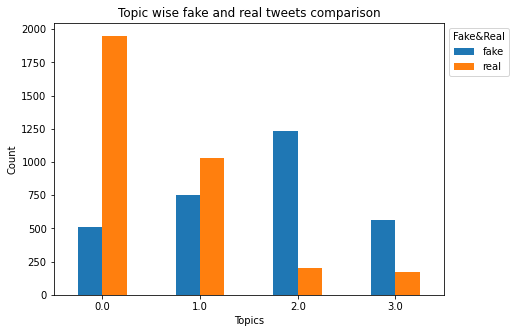

In [ ]:

# plot
ax = dfu.plot(kind='bar', figsize=(7, 5), xlabel='Topics', ylabel='Count', rot=0)
ax.legend(title='Fake&Real', bbox_to_anchor=(1, 1), loc='upper left')
plt.title("Topic wise fake and real tweets comparison")

In [ ]:
#Hyper parameter tuning

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tweets_data, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, len(corpus)*0.75), 
               corpus]

In [ ]:
import tqdm
import numpy as np
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 7
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.5))]
corpus_title = ['50% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=25)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()




  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)



  4%|▍         | 1/25 [00:12<04:53, 12.23s/it]


  8%|▊         | 2/25 [00:26<05:08, 13.43s/it]


 12%|█▏        | 3/25 [00:42<05:19, 14.53s/it]


 16%|█▌        | 4/25 [00:58<05:21, 15.32s/it]


 20%|██        | 5/25 [01:14<05:06, 15.30s/it]


 24%|██▍       | 6/25 [01:26<04:32, 14.32s/it]


 28%|██▊       | 7/25 [01:42<04:24, 14.72s/it]


 32%|███▏      | 8/25 [01:59<04:24, 15.58s/it]


 36%|███▌      | 9/25 [02:17<04:23, 16.48s/it]


 40%|████      | 10/25 [02:34<04:07, 16.53s/it]


 44%|████▍     | 11/25 [02:47<03:33, 15.27s/it]


 48%|████▊     | 12/25 [03:02<03:17, 15.18s/it]


 52%|█████▏    | 13/25 [03:19<03:08, 15.75s/it]


 56%|█████▌    | 14/25 [03:36<03:00, 16.37s/it]


 60%|██████    | 15/25 [03:52<02:42, 16.23s/it]


 64%|██████▍   | 16/25 [04:04<02:14, 14.95s/it]


 68%|█████

In [ ]:
cd '/content/drive/MyDrive/FakeNewsData/fakeNewsData'

/content/drive/MyDrive/FakeNewsData/fakeNewsData


In [ ]:
 pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)

In [ ]:
model_results_df = pd.DataFrame(model_results)

In [ ]:
model_results_df.columns

Index(['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence'], dtype='object')

In [ ]:
import seaborn as sns

Text(0.5, 1.0, 'Topic coherence for determining optimal topics')

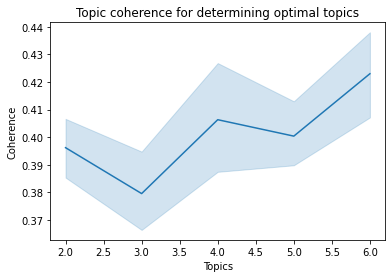

In [ ]:
ax = sns.lineplot(data= model_results_df, x="Topics", y="Coherence")
ax.set_title("Topic coherence for determining optimal topics")